# TakagiTaupin - Calculate the Takagi-Taupin curves

This file demonstrates the usage of TakagiTaupin that is the main class of the package. TakagiTaupin solves the TT-equations for deformed crystal using the information given to it in TTcrystal and TTscan. For detailed instruction on their use, please refer to the respective documentation and example Jupyter notebooks.

In [1]:
import sys
import os.path

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1, '..')
from pyTTE import TakagiTaupin, TTcrystal, TTscan, Quantity

### First example: rocking curve of a perfect Si crystal in the Bragg case

Let us start with a simple example of calculating the rocking curve of the (111) reflection of a 1 mm thick Si perfect, single crystal. First we define the crystal using TTcrystal class:

In [7]:
xtal = TTcrystal(crystal='Si', hkl=[1,1,1], thickness=Quantity(1,'mm'))

The given keywords `crystal`, `hkl`, and `thickness` are the required minimum amount of parameters to define a crystal. To avoid conversion errors, all the quantities with physical units are handled in _pyTTE_ using the Quantity class which supports most units commonly used in the context of X-ray diffraction.

Full information of a TTcrystal instance can be seen by passing it to the `print` function:

In [8]:
print(xtal)

Crystal: Si
Crystallographic parameters:
    a = 0.543069 nm,  b = 0.543069 nm,  c = 0.543069 nm
    alpha = 90.0 deg,  beta = 90.0 nm,  gamma = 90.0 deg
Direct primitive vectors (before rotations, in nm):
    a1 = [0.5431 0.     0.    ]
    a2 = [0.     0.5431 0.    ]
    a3 = [0.     0.     0.5431]
Reciprocal primitive vectors (before rotations, in 1/nm):
    b1 = [11.5698 -0.     -0.    ]
    b2 = [ 0.     11.5698 -0.    ]
    b3 = [ 0.      0.     11.5698]

Reflection: [1, 1, 1]
Asymmetry angle: 0 deg
In-plane rotation angle: 0 deg
Crystal directions parallel to the Cartesian axes (after rotations):
    x || [ 1.     -0.2679 -0.7321]
    y || [-0.2679  1.     -0.7321]
    z || [1. 1. 1.]

Crystal thickness: 1 mm
Debye-Waller factor: 1.0

Deformation model: anisotropic toroidal, fixed shape (built-in)
Meridional bending radius: inf m
Sagittal bending radius: inf m
Material elastic isotropy: anisotropic
Compliance matrix S (with rotations applied):
[[ 0.0059 -0.0015 -0.001  -0.0012  

In addition to the crystal parameters, we need to define the scan using the TTscan class. Let's fix the photon energy of the incident beam to 5 keV, use $\sigma$-polarization and scan the rocking angle from -50 to 150 µrad in 150 steps. In _pyTTE_, all scans are performed relative to the values fulfilling the kinematical Bragg condition $\lambda = 2 d \sin \theta$.  

In [14]:
scan = TTscan(constant = Quantity(5,'keV'), scan = Quantity(np.linspace(-50,150,150),'urad'), polarization = 'sigma')
print(scan)

Scan type     : angle
Scan constant : 5 keV
Polarization  : sigma
Scan points   : 150
Scan range    : manual from -50.0 to 150.0 urad

Integrator                 : zvode_bdf
(Minimum) integration step : 1e-10 um
Alternative starting depth : None



The rocking curve is now calculated by initializing the TakagiTaupin instance with the crystal and scan parameter instances, and calling `.run()`.

In [16]:
tt = TakagiTaupin(xtal, scan)

scan_vector, reflectivity, transmission = tt.run()


Solving the 1D Takagi-Taupin equation for Si(1,1,1) reflection
---------------------------------------------------------------

The direction of diffraction out of the crystal -> Bragg case
Solving for sigma-polarization
Asymmetry angle :  0 deg
Wavelength      :  0.247968386 nm
Energy          :  5.0 keV
Bragg angle     :  23.292879649001986 deg
Incidence angle :  23.292879649001986 deg
Exit angle      :  23.292879649001986 deg

Structure factors
F0   :  (115.0489207774186+6.498559984990174j)
Fh   :  (46.915823878813626-40.417263893823474j)
Fb   :  (40.417263893823446+46.91582387881365j)

Susceptibilities
chi0 :  (-3.961773705462428e-05+2.237815348282492e-06j)
chih :  (-1.615572542160448e-05-1.3917910073321994e-05j)
chib :  (-1.3917910073321984e-05+1.6155725421604487e-05j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
Solving...0%
Done.


(Note that Jupyter does not update the solving process in the notebook but in the terminal/command prompt.)

`.run()` returns the solution but also stores it in `.solution` with all the relevant information and settings pertaining to it. The stored solution can be quickly visualized by calling `.plot()`

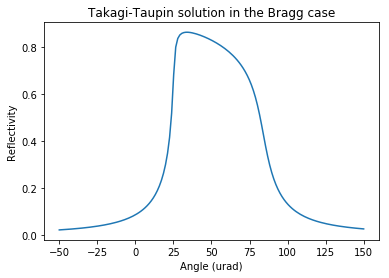

In [17]:
tt.plot()

For reference, the same curve was calculated using _XCRYSTAL_ in _XOP_ 2.4 (http://dx.doi.org/10.1117/12.560903) with the EPDL97 anomalous scattering cross-sections, that are also used by _xraylib_. 

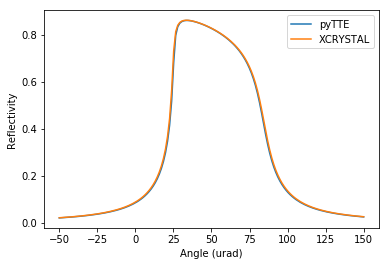

In [24]:
ref = np.loadtxt('reference_spectra/xop_Si_111_bragg.dat')

plt.plot(scan_vector,reflectivity)
plt.plot(ref[:,0],ref[:,1])
plt.legend(['pyTTE','XCRYSTAL'])
plt.ylabel('Reflectivity')
plt.xlabel('Angle (urad)')
plt.show()

The result is practically identical with the one calculated with _pyTTE_. Nearly insignificant deviations are probably explained by slight differences in structure factors: 

_PyTTE_ output:
```
F0   :  (115.0489207774186+6.498559984990174j)
Fh   :  (46.915823878813626-40.417263893823474j)
Fb   :  (40.417263893823446+46.91582387881365j)
```

_Crystal Parameters_ of `XCRYSTAL`:
```
 Structure factor F(0,0,0) =  (  115.01669312000000     ,  6.5506672799999999     )
 Structure factor FH =  (  47.595073721453730     , -41.044406441453731     )
 Structure factor FH_BAR =  (  41.044406441453731     ,  47.595073721453730     )
```

### Second example: The Laue case and automatic scan limits

_PyTTE_ does not require explicit differentiation between the Bragg case (reflection geometry) and the Laue case (transmission geometry) since the diffraction geometry is determined automatically from the propagation direction of the diffracted beam. This can be controlled via the asymmetry angle. For a symmetric Laue case, asymmetry angle is set to 90 degrees:

In [26]:
xtal = TTcrystal(crystal='Ge', hkl=[4,0,0], thickness=Quantity(100,'um'), asymmetry = Quantity(90,'deg'))

In the previous example we defined the scan points manually but it can be inconvenient to iterate good values for the scan limits, especially with bent crystals. To make the task easier, _pyTTE_ can try to determine the limits automatically by giving `TTscan` the number of scan points instead of a scan vector. 

In [31]:
scan = TTscan(constant = Quantity(7,'keV'), scan = 150, polarization = 'sigma')
print(scan)

Scan type     : angle
Scan constant : 7 keV
Polarization  : sigma
Scan points   : 150
Scan range    : automatic

Integrator                 : zvode_bdf
(Minimum) integration step : 1e-10 um
Alternative starting depth : None




Solving the 1D Takagi-Taupin equation for Ge(4,0,0) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
Theta min: -100.21483794864227 urad
Theta max: 100.22290397615485 urad

The direction of diffraction in to the crystal -> Laue case
Solving for sigma-polarization
Asymmetry angle :  90 deg
Wavelength      :  0.17712027571428574 nm
Energy          :  7.0 keV
Bragg angle     :  38.7673720607094 deg
Incidence angle :  128.76737206070942 deg
Exit angle      :  -51.2326279392906 deg

Structure factors
F0   :  (249.73280927589715+9.339607731323417j)
Fh   :  (157.1390925424523+9.339607731323358j)
Fb   :  (157.1390925424523+9.339607731323472j)

Susceptibilities
chi0 :  (-3.8811010956508024e-05+1.451469748972486e-06j)
chih :  (-2.4421008437153955e-05+1.451469748972477e-06j)
chib :  (-2.4421008437153955e-05+1.4514697489724946e-06j)

(Mean F and chi values for energy scan)


Calculating the TT-curve using 4 cores.
Solving...0%

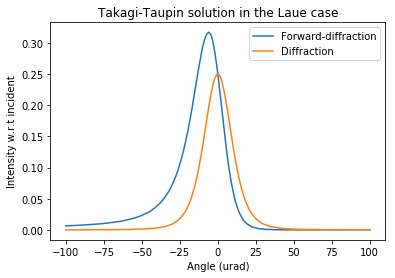

In [39]:
tt = TakagiTaupin(xtal, scan)

scan_vector, diffracted, transmission = tt.run()
tt.plot()

Also in this case, the correspondence with _XCRYSTAL_ is practically perfect. 

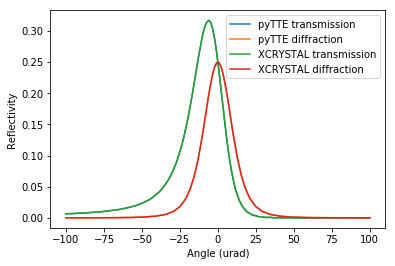

In [41]:
ref = np.loadtxt('reference_spectra/xop_Ge_400_laue_transmission.dat')
ref2 = np.loadtxt('reference_spectra/xop_Ge_400_laue_diffraction.dat')

plt.plot(scan_vector,transmission)
plt.plot(scan_vector,diffracted)
plt.plot(ref[:,0],ref[:,1])
plt.plot(ref2[:,0],ref2[:,1])
plt.legend(['pyTTE transmission', 'pyTTE diffraction', 'XCRYSTAL transmission', 'XCRYSTAL diffraction'])
plt.ylabel('Reflectivity')
plt.xlabel('Angle (urad)')
plt.show()

### Third example: bent crystals and energy scans

Deformation can be introduced by passing the meridional and sagittal bending radii (`Rx` and `Ry`, respectively) to TTcrystal. In the case of spherical bending, a single keyword `R` can be used.


Solving the 1D Takagi-Taupin equation for Si(6,6,0) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -382.2324461218393 meV
E max: 413.26703657958467 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for pi-polarization
Asymmetry angle :  5 deg
Wavelength      :  0.1236412431724223 nm
Energy          :  10.027737494284125 keV
Bragg angle     :  75.0 deg
Incidence angle :  80.0 deg
Exit angle      :  70.0 deg

Structure factors
F0   :  (113.56318578240287+1.758716852254629j)
Fh   :  (32.4906364543163+1.7587168522545933j)
Fb   :  (32.4906364543163+1.758716852254665j)

Susceptibilities
chi0 :  (-9.722518519838743e-06+1.50569544605429e-07j)
chih :  (-2.7816304418732393e-06+1.5056954460542595e-07j)
chib :  (-2.7816304418732393e-06+1.5056954460543206e-07j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
Solv

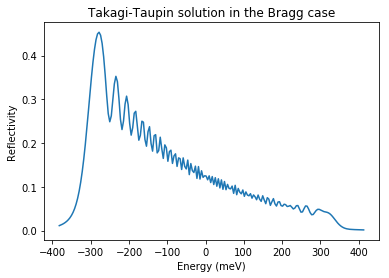

In [103]:
ttx = TTcrystal(crystal='Si', hkl=[6,6,0], thickness=Quantity(150,'um'), R = Quantity(100,'cm'), asymmetry = Quantity(5, 'deg'))
tts = TTscan(scan = 200, constant = Quantity(75, 'deg'), polarization = 'pi')

tt = TakagiTaupin(ttx,tts)

tt.run()
tt.plot()

By default _pyTTE_ attempts to calculate the toroidal/spherical/cylindrical bending using elastic constants from a built-in compliance matrix $S$ (Source: CRC Handbook of Chemistry and Physics, 82nd edition). 

For anisotropic crystals, _PyTTE_ has two different deformation models, selected with the TTcrystal keyword `fix_to_axis`. The default value is `'shape'` which assumes that the main axes of curvature are along the coordinate axes $x$ and $y$, and are given by `Rx` and `Ry`. This corresponds to the situation where the crystal is forced to a specific shape _e.g._ by the substrate. The other option is `torques` which assumes that the crystal is bent by two orthogonal torques acting about the aforemention coordinate axes. This applies, for example, when a free standing crystal slab is bent by its ends. In the general case these models are not equal due to non-diagonal elements of $S$. See TTcrystal.ipynb, help(TTcrystal) or the technical docs for more information.

Built-in $S$:s are available only for a handful of crystals commonly encountered in X-ray optics. In other cases user needs to define $S$ manually with the keyword `S`. Alternatively, an isotropic deformation model can be used by giving Poisson's ratio $\nu$ with `nu`. Also Young's modulus $E$ is required but its value is not important here as it is not used in by deformation model. `fix_to_axes` is neglected as the two anisotropic models reduce to the same isotropic model. 


Solving the 1D Takagi-Taupin equation for Si(6,6,0) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -396.7773903713954 meV
E max: 427.8119808291406 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for pi-polarization
Asymmetry angle :  5 deg
Wavelength      :  0.1236412431724223 nm
Energy          :  10.027737494284125 keV
Bragg angle     :  75.0 deg
Incidence angle :  80.0 deg
Exit angle      :  70.0 deg

Structure factors
F0   :  (113.56318578247442+1.7587168524648462j)
Fh   :  (32.49063645438787+1.7587168524648105j)
Fb   :  (32.49063645438786+1.758716852464882j)

Susceptibilities
chi0 :  (-9.722518519844868e-06+1.5056954462342635e-07j)
chih :  (-2.781630441879366e-06+1.5056954462342328e-07j)
chib :  (-2.781630441879365e-06+1.5056954462342942e-07j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
So

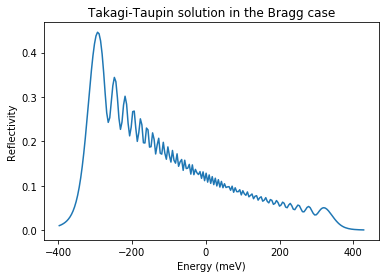

In [104]:
ttx = TTcrystal(crystal='Si', hkl=[6,6,0], thickness=Quantity(150,'um'), R = Quantity(100,'cm'), asymmetry = Quantity(5, 'deg'), nu = 0.22, E = Quantity(150, 'GPa'))
tts = TTscan(scan = 200, constant = Quantity(75, 'deg'), polarization = 'pi')

tt = TakagiTaupin(ttx,tts)

tt.run()
tt.plot()

Also custom deformation fields can be defined by providing the Jacobian of the displacement vector $\mathbf{u}$ as a function of $x$ and $z$:

$\begin{equation}
J(x,z) = \left[\begin{matrix}
\frac{\partial u_x}{\partial x}(x,z) & \frac{\partial u_x}{\partial z}(x,z) \\
\frac{\partial u_z}{\partial x}(x,z) & \frac{\partial u_z}{\partial z}(x,z)
\end{matrix}\right]
\end{equation}$

For reference, we do this for the isotropic bending below. Note that the lengths are exceptionally required to be in micrometers.


Solving the 1D Takagi-Taupin equation for Si(6,6,0) reflection
---------------------------------------------------------------

Using automatically determined scan limits:
E min: -396.7773903713954 meV
E max: 427.8119808291406 meV

The direction of diffraction out of the crystal -> Bragg case
Solving for pi-polarization
Asymmetry angle :  5 deg
Wavelength      :  0.1236412431724223 nm
Energy          :  10.027737494284125 keV
Bragg angle     :  75.0 deg
Incidence angle :  80.0 deg
Exit angle      :  70.0 deg

Structure factors
F0   :  (113.56318578247442+1.7587168524648462j)
Fh   :  (32.49063645438787+1.7587168524648105j)
Fb   :  (32.49063645438786+1.758716852464882j)

Susceptibilities
chi0 :  (-9.722518519844868e-06+1.5056954462342635e-07j)
chih :  (-2.781630441879366e-06+1.5056954462342328e-07j)
chib :  (-2.781630441879365e-06+1.5056954462342942e-07j)

(Mean F and chi values for energy scan)

Transmission in the Bragg case not implemented!

Calculating the TT-curve using 4 cores.
So

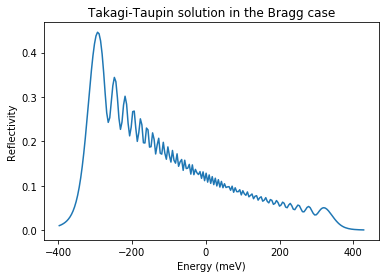

In [112]:
def jacobian(x,z):
    nu = 0.22
    R_bend_in_um = 1e6
    thickness_in_um = 150

    ux_x = -(z+0.5*thickness_in_um)/R_bend_in_um 
    ux_z = -x/R_bend_in_um 

    uz_x = x/R_bend_in_um 
    uz_z = 2*nu/(1-nu)/R_bend_in_um*(z+0.5*thickness_in_um)

    return [[ux_x,ux_z],[uz_x,uz_z]]

ttx = TTcrystal(crystal='Si', hkl=[6,6,0], thickness=Quantity(150,'um'), asymmetry = Quantity(5, 'deg'))
tts = TTscan(scan = 200, constant = Quantity(75, 'deg'), polarization = 'pi')

#The custom Jacobian is given to TTcrystal after the initialization
ttx.set_deformation(jacobian = jacobian)

tt = TakagiTaupin(ttx,tts)

tt.run()
tt.plot()

### Fourth example: Initialization from file

Parameters can also be defined in 


CRYSTAL PARAMETERS
------------------

Crystal: LiF
Crystallographic parameters:
    a = 0.402629 nm,  b = 0.402629 nm,  c = 0.402629 nm
    alpha = 90.0 deg,  beta = 90.0 nm,  gamma = 90.0 deg
Direct primitive vectors (before rotations, in nm):
    a1 = [0.4026 0.     0.    ]
    a2 = [0.     0.4026 0.    ]
    a3 = [0.     0.     0.4026]
Reciprocal primitive vectors (before rotations, in 1/nm):
    b1 = [15.6054 -0.     -0.    ]
    b2 = [ 0.     15.6054 -0.    ]
    b3 = [ 0.      0.     15.6054]

Reflection: [2, 0, 0]
Asymmetry angle: 2.5 deg
In-plane rotation angle: 0 deg
Crystal directions parallel to the Cartesian axes (after rotations):
    x || [ 0.0437  0.     -1.    ]
    y || [0. 1. 0.]
    z || [ 1.     -0.      0.0437]

Crystal thickness: 200.0 um
Debye-Waller factor: 1.0

Deformation model: anisotropic toroidal, fixed shape (built-in)
Meridional bending radius: 1.0 m
Sagittal bending radius: inf m
Material elastic isotropy: anisotropic
Compliance matrix S (with rotations

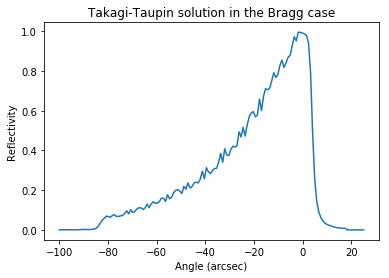

In [128]:
'''
Contents of TTcrystal_init.inp:

crystal LiF
hkl 2 0 0
thickness 200 um
asymmetry 2.5 deg
Rx 1 m

Contents of TTscan_init.inp:

constant 8 keV
scan -100 25 150 arcsec
polarization sigma
solver zvode_bdf
integration_step 1 nm
'''

tt = TakagiTaupin('TTcrystal_init.inp','TTscan_init.inp')

print(tt)

tt.run()
tt.plot()
plt.show()